In [1]:
import cv2 as cv
from matplotlib import pyplot as plt
import time
import numpy as np
import os

# cv compatibility with Wayland (run opencv with QT_QPA_PLATFORM=xcb)
#import os
#os.environ["QT_QPA_PLATFORM"] = "xcb"

In [2]:
WEIGHT_PATH = "../yolo_weights/eu_dataset_256_160/yolov4-tiny_best_eudataset_downsampled.weights"
CONFIG_PATH = "../yolo_weights/eu_dataset_256_160/yolov4-tiny_downsampled.cfg"

DIMS = (256, 160)

IMAGE_FOLDER = "../eu_dataset/images/"

In [3]:
net = cv.dnn.readNetFromDarknet(CONFIG_PATH, WEIGHT_PATH)
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)

In [4]:
# determine the output layer
ln = net.getLayerNames()
print(ln)
print(net.getUnconnectedOutLayers())
ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]

('conv_0', 'bn_0', 'leaky_1', 'conv_1', 'bn_1', 'leaky_2', 'conv_2', 'bn_2', 'leaky_3', 'slice_3', 'conv_4', 'bn_4', 'leaky_5', 'conv_5', 'bn_5', 'leaky_6', 'concat_6', 'conv_7', 'bn_7', 'leaky_8', 'concat_8', 'pool_9', 'conv_10', 'bn_10', 'leaky_11', 'slice_11', 'conv_12', 'bn_12', 'leaky_13', 'conv_13', 'bn_13', 'leaky_14', 'concat_14', 'conv_15', 'bn_15', 'leaky_16', 'concat_16', 'pool_17', 'conv_18', 'bn_18', 'leaky_19', 'slice_19', 'conv_20', 'bn_20', 'leaky_21', 'conv_21', 'bn_21', 'leaky_22', 'concat_22', 'conv_23', 'bn_23', 'leaky_24', 'concat_24', 'pool_25', 'conv_26', 'bn_26', 'leaky_27', 'conv_27', 'bn_27', 'leaky_28', 'conv_28', 'bn_28', 'leaky_29', 'conv_29', 'permute_30', 'yolo_30', 'identity_31', 'conv_32', 'bn_32', 'leaky_33', 'upsample_33', 'concat_34', 'conv_35', 'bn_35', 'leaky_36', 'conv_36', 'permute_37', 'yolo_37')
[66 78]


In [5]:
# take random image from image folder
random_image = np.random.choice(os.listdir(IMAGE_FOLDER))
raw_img = cv.imread(os.path.join(IMAGE_FOLDER, random_image))
blob = cv.dnn.blobFromImage(raw_img, 1/255.0, DIMS, swapRB=True, crop=False)

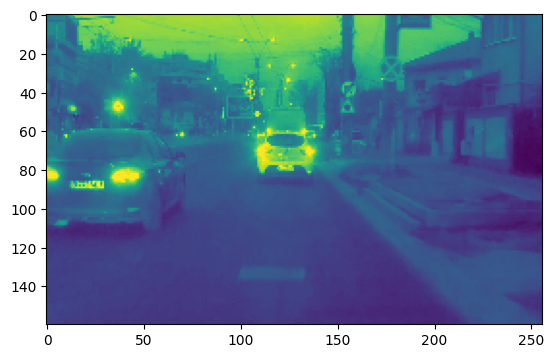

In [6]:
r = blob[0, 0, :, :]
plt.imshow(r)

In [7]:
net.setInput(blob)
t0 = time.time()
outputs = net.forward(ln)
t = time.time()

elapsed_ms = (t - t0)*1000
fps = 1.0/(t - t0)

print('time=', elapsed_ms)
print('fps=', fps)

time= 133.67700576782227
fps= 7.48071812542582


In [8]:
print(len(outputs))
for out in outputs:
    print(out.shape)

2
(120, 6)
(480, 6)


In [9]:
boxes = []
confidences = []
classIDs = []
h, w = raw_img.shape[:2]

In [10]:
for output in outputs:
    for detection in output:
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]

        box = detection[:4] * np.array([w, h, w, h])
        (centerX, centerY, width, height) = box.astype("int")
        x = int(centerX - (width / 2))
        y = int(centerY - (height / 2))
        box = [x, y, int(width), int(height)]
        boxes.append(box)
        confidences.append(float(confidence))
        classIDs.append(classID)


In [11]:
boxes

[[-230, -174, 515, 498],
 [-118, -286, 409, 761],
 [-764, -1090, 1661, 2362],
 [-68, -118, 516, 411],
 [92, -154, 334, 535],
 [-1079, -960, 2595, 2055],
 [19, -39, 642, 250],
 [248, -177, 354, 594],
 [-1009, -875, 2742, 1919],
 [102, -42, 782, 252],
 [408, -295, 359, 844],
 [-375, -797, 1805, 1765],
 [269, -75, 774, 295],
 [545, -241, 361, 730],
 [166, -732, 1052, 1641],
 [386, -85, 886, 309],
 [729, -208, 296, 663],
 [72, -811, 1565, 1783],
 [613, -83, 770, 319],
 [804, -113, 439, 479],
 [388, -1357, 1270, 2843],
 [807, -83, 721, 291],
 [1025, -194, 302, 613],
 [301, -1304, 1756, 2745],
 [-110, 22, 278, 439],
 [-203, 31, 539, 384],
 [-1088, -1504, 2332, 3533],
 [42, 41, 293, 428],
 [-157, 118, 752, 274],
 [-1079, -2525, 2612, 5566],
 [150, 139, 406, 208],
 [18, 44, 757, 425],
 [-881, -2662, 2497, 5865],
 [304, 177, 430, 128],
 [145, 60, 796, 384],
 [-619, -1608, 2307, 3752],
 [431, 174, 512, 137],
 [241, 13, 865, 465],
 [109, -896, 1137, 2319],
 [520, 113, 668, 208],
 [548, 65, 587, 3

In [12]:
indices = cv.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

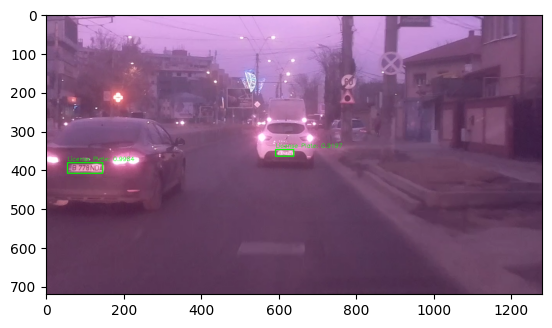

In [13]:
display_img = raw_img.copy()

for i in indices:
    box = boxes[i]
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]
    cv.rectangle(display_img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    label = "{}: {:.4f}".format('License Plate', confidences[i])
    cv.putText(display_img, label, (x, y - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

plt.imshow(display_img[:,:,::-1])
plt.show()

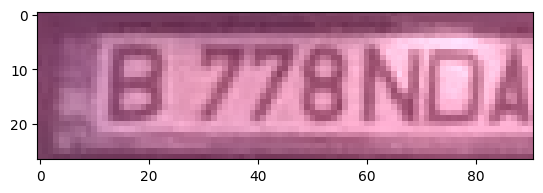

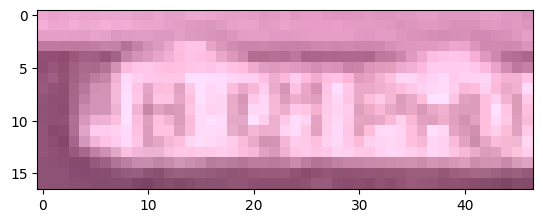

In [14]:
# only show the license plate
for i in indices:
    box = boxes[i]
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]
    roi = raw_img[y:y+h, x:x+w]
    plt.imshow(roi[:,:,::-1])
    plt.show()